# 1. Map Visualizations 

Here I will write some functions that will make visualizations easy on a "heat-map" of the United States.

## 1.1 Wheat Production by State

### Setup and Plotting code

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Code to plot State Chloropleth maps in matplotlib. "make_map" is the function actually used to create the maps.

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        if state not in states:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [4]:
wheat_production_by_state=pd.read_csv("state_wheat_production_by_year.csv")

In [5]:
#change the states to lowercase except first letter 
wheat_production_by_state['State'] = wheat_production_by_state['State'].map(lambda x: x.title())
#remove the commas from the production values and change the production values to floats 
wheat_production_by_state['Value'] = wheat_production_by_state['Value'].map(lambda x: float(x.replace(',','')))
wheat_production_by_state.head(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2015,YEAR,NaN,STATE,Alabama,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,14960000,NaN
1,SURVEY,2015,YEAR,NaN,STATE,Arizona,4,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,14346000,NaN
2,SURVEY,2015,YEAR,NaN,STATE,Arkansas,5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,13440000,NaN


C:\Users\Vinh\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


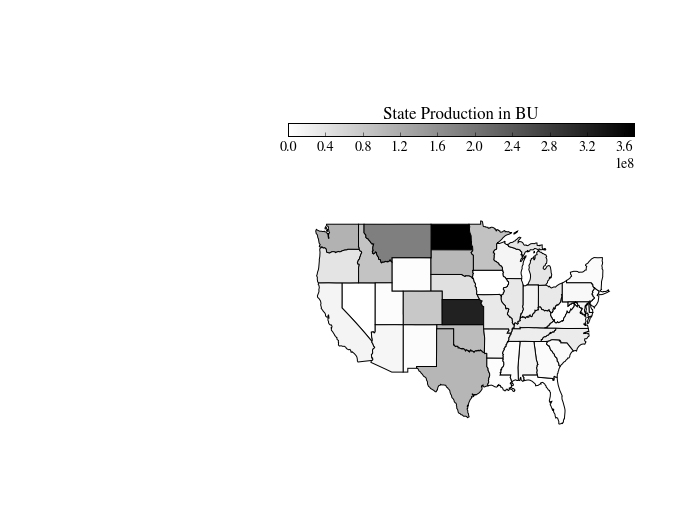

In [6]:
make_map(wheat_production_by_state.loc[wheat_production_by_state['Year'] == 2015].set_index('State').Value,"State Production in BU")

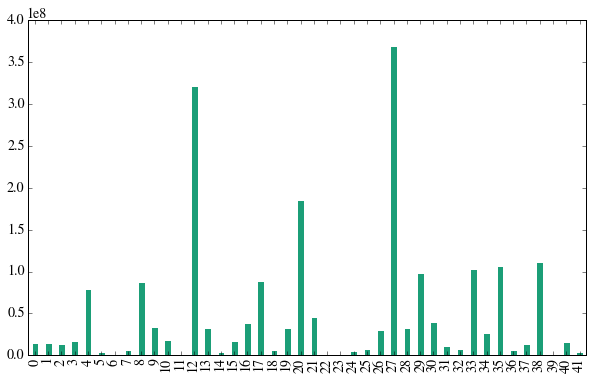

In [7]:
wheat_production_by_state.loc[wheat_production_by_state['Year'] == 2015].Value.plot(kind='bar')

## 1.2 Precipitation 

In [8]:
prec = pd.read_csv("precdf.csv")

In [9]:
prec.head(10)

,State,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AS,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66
1,AS,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95
2,AS,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42
3,AS,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87
4,AS,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51
5,AS,1986,85.73,42.12,27.99,70.95,50.12,31.35,38.78,29.89,63.68,47.40,43.12,83.10
6,AS,1987,51.46,76.48,39.54,35.73,31.18,27.88,20.43,34.98,8.41,26.69,22.98,62.08
7,AS,1988,33.36,47.98,49.08,44.00,42.97,28.17,38.78,25.48,37.92,46.45,59.69,89.15
8,AS,1989,55.23,58.06,32.73,53.88,36.72,30.79,41.66,2.09,7.88,49.82,63.79,37.31
9,AS,1990,49.32,68.57,32.88,45.18,16.35,35.98,22.14,15.41,26.11,54.39,45.25,35.30


In [37]:
#prec_new = prec.groupby(['State','Year'])
prec_grouped = prec.groupby(['State','Year']).mean().reset_index()
prec_grouped

,State,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AK,1981,15.683362,8.257069,8.708879,3.853276,4.915259,6.550172,10.535862,15.486552,12.651207,12.820948,12.226121,7.486121
1,AK,1982,5.100342,3.618462,5.281624,5.847863,6.187179,5.819829,7.964359,6.752137,15.152222,11.733419,9.297863,9.896068
2,AK,1983,7.984655,6.574655,2.432241,7.119828,6.262931,4.087155,6.538879,13.819310,10.171466,13.382414,8.525172,3.358017
3,AK,1984,12.432069,8.805259,6.767759,5.168362,4.187759,6.101121,8.322500,10.346638,8.663448,9.372586,7.268966,10.093190
4,AK,1985,15.284348,7.119652,8.681217,5.548087,5.936609,7.537130,5.375565,10.198435,13.984087,9.077913,4.656261,15.266783
5,AK,1986,12.364872,6.162650,6.593077,4.190427,4.491368,4.831368,7.465470,11.689744,8.029231,18.506838,10.268120,15.018718
6,AK,1987,13.020000,7.321282,5.140513,5.975641,6.503419,10.063504,6.694017,5.087863,17.302222,17.963675,13.330855,10.894957
7,AK,1988,7.215470,9.894017,9.811880,7.323504,6.320000,6.074530,6.445641,11.865556,10.154017,14.196752,10.109829,13.272650
8,AK,1989,8.603621,2.369569,2.484310,4.185862,7.217845,6.950517,6.059138,10.700517,14.211724,15.089397,10.749397,15.118621
9,AK,1990,9.548205,7.374872,7.928034,3.385556,3.875385,5.460855,7.563504,10.194103,18.809231,10.304786,6.216667,11.274872


In [39]:
def make_map_prec(year, start_month, end_month): 
    input_df = prec_grouped.loc[prec['Year'] == year]
    input_df['cumulative_rainfall'] = (prec_grouped.ix[:,start_month:end_month]).sum(axis=1)
    print input_df.cumulative_rainfall

In [40]:
make_map_prec(1999,'March','August')

18       46.079646
48       69.334762
63       67.120576
91      179.640000
114     217.775000
135      11.845698
164      39.358710
189      28.029954
210      40.765152
233      66.759394
263      75.135000
293      76.111379
323     214.541111
353      57.325072
383     212.920000
413      85.629118
443      64.955000
473      19.981379
503      63.865179
533      67.978425
562      48.686177
586      81.302647
616      85.401939
646      55.864805
680      62.056889
696      49.377403
709      59.511948
724     147.303333
745     120.633333
767      42.827594
           ...    
888      64.896124
918      23.509322
948      55.848805
978      41.010000
1008     53.900667
1038     47.639600
1068     48.093333
1098     30.809290
1128      9.895347
1158     42.648238
1188     43.790903
1218     63.468291
1248     25.907435
1278     47.574639
1308     74.167077
1338    252.055000
1368     40.381250
1398     51.319785
1428     44.942917
1458     62.401961
1488     42.185240
1518     27.

C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
